### Problem 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy.io import wavfile
import scipy.signal as signal

nperseg = 1024
noverlap = 512
numTimeBins = -1 #set below in function
music_path = "./SpeechMusic/music/"
speech_path = "./SpeechMusic/speech/"

music_files = [f for f in os.listdir(music_path) if f.endswith('.wav')]
speech_files = [f for f in os.listdir(speech_path) if f.endswith('.wav')]

musicTrain = []
speechTrain = []
musicTest = []
speechTest = []

numTest = 6
sampleRate = 0 #stored incase i need later
musicTestIndex = np.random.choice(len(music_files), numTest, replace=False)
speechTestIndex = np.random.choice(len(speech_files), numTest, replace=False)

for i, file in enumerate(music_files):
    sampleRate, data = wavfile.read(os.path.join(music_path, file))
    __,__, data = signal.stft(data, window='hamming', nperseg=nperseg, noverlap=noverlap)
    numTimeBins = data.shape[1]
    data = np.log10(np.abs(data))
    if i in musicTestIndex:
        musicTest.append(data)
    else:
        musicTrain.append(data)

for i, file in enumerate(speech_files):
    sampleRate, data = wavfile.read(os.path.join(speech_path, file))
    __,__, data = signal.stft(data, window='hamming', nperseg=nperseg, noverlap=noverlap)
    data = np.log10(np.abs(data))
    if i in speechTestIndex:
        speechTest.append(data)
    else:
        speechTrain.append(data)

musicTrain = np.hstack(musicTrain)
speechTrain = np.hstack(speechTrain)
musicTest = np.hstack(musicTest)
speechTest = np.hstack(speechTest)

#these matrices are all spectrograms hstacked for a bunch of audio files
print("Music Train Matrix Shape:", musicTrain.shape)
print("Speech Train Matrix Shape:", speechTrain.shape)
print("Music Test Matrix Shape:", musicTest.shape)
print("Speech Test Matrix Shape:", speechTest.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'friends.wav'

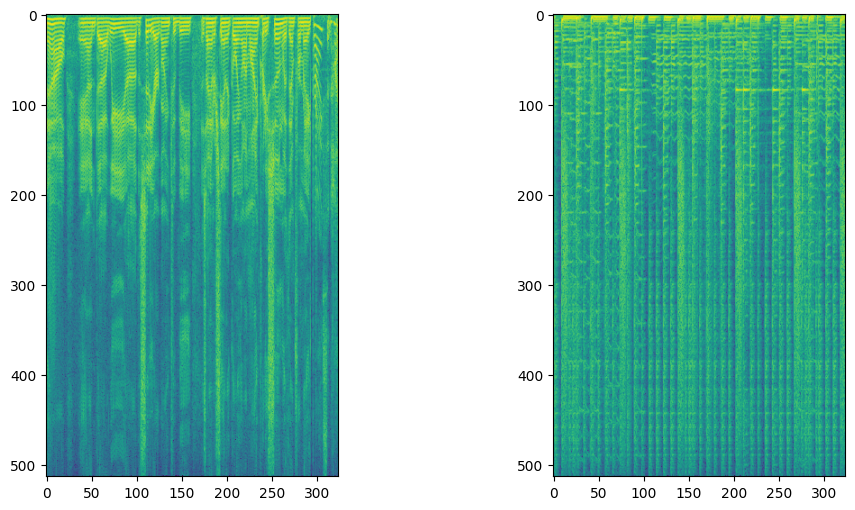

In [17]:
#324 time samples per spect
plt.figure(figsize=(12,6))
numImage = 0
plt.subplot(1,2,1)
plt.imshow(speechTrain[:,i*324:(i+1)*324])

plt.subplot(1,2,2)
plt.imshow(musicTrain[:,i*324:(i+1)*324])

### The below cell gets my LDA vectors in the rows of the geneigvecs matrix. Sorted from highest eigenval to lowest eigenval I only keep the first eigenvec as the eigenvals following were much smaller 


In [18]:

from scipy.linalg import eigh

BetweenCov = np.zeros((nperseg//2 + 1,nperseg//2 + 1)) # since nfft +1 as we cut specotrgram and keep DC term
WithinCov = np.zeros((nperseg//2 + 1,nperseg//2 + 1))

totalMean = np.mean(np.hstack((musicTrain, speechTrain)), axis = 1)
speechMean  = np.mean(speechTrain, axis=1)
musicMean = np.mean(musicTrain, axis =1)

BetweenCov += (speechMean - totalMean).reshape(-1,1) @ (speechMean - totalMean).reshape(1,-1)
BetweenCov += (musicMean - totalMean).reshape(-1,1) @ (musicMean - totalMean).reshape(1,-1)

for j in range(musicTrain.shape[1]):
    leftMusic = (musicTrain[:,j] - musicMean).reshape(-1,1)
    rightMusic = (musicTrain[:,j] - musicMean).reshape(1,-1) 
    leftSpeech = (speechTrain[:,j] - speechMean).reshape(-1,1)
    rightSpeech = (speechTrain[:,j] - speechMean).reshape(1,-1) 
    WithinCov += leftMusic @ rightMusic + leftSpeech @ rightSpeech

geneigvals, geneigvecs = eigh(BetweenCov, WithinCov, eigvals_only=False)

geneigvals = geneigvals[::-1]
geneigvecs =  geneigvecs[:,::-1]

geneigvecs = geneigvecs.T

LDAvector = geneigvecs[0].reshape(1,-1)

# file_name = "LDAvector.npy"
# # np.save(file_name, geneigvecs[0])

# LDAvector = np.load(file_name).reshape(1,-1)
totalMean = np.mean(np.hstack((musicTrain, speechTrain)), axis = 1).reshape(-1,1)



In [19]:
musicproj = LDAvector @ (musicTrain -totalMean.reshape(-1,1))
speechproj = LDAvector @ (speechTrain -totalMean.reshape(-1,1))

In [20]:

print(f"Mean Projection for Music train and Speech Train spec columns: {np.mean(musicproj), np.mean(speechproj)}")
print("so 0 is our decision boundary")



Mean Projection for Music train and Speech Train spec columns: (-0.004427664289091338, 0.004427645999380571)
so 0 is our decision boundary


### I compute the average value of my LDA vector over the columns of stfts for music and speech and notice midpoint is 0.   


### I now make the decision rule for my classifier that if the mean of the (LDA vector) @ (spectrogram columns) > 0 it is speech if it is < 0 it is music

Total Train Accuracy per second of audio: 0.958743842364532
[[792.  20.]
 [ 47. 765.]]


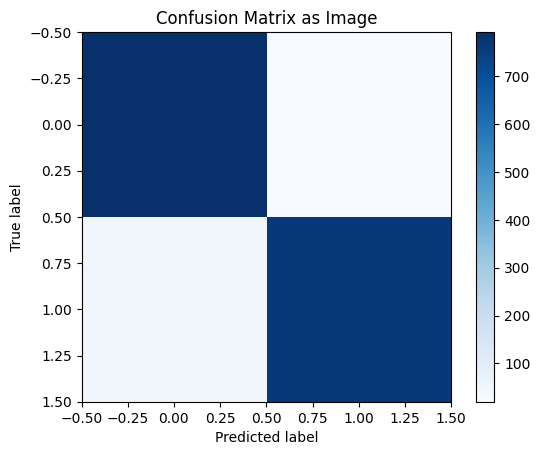

In [21]:
#Confusion Matrix generation (conf[0] is speech conf[1] is music)
conf_mat = np.zeros((2,2))

numTimeBins = numTimeBins//15 # since each recording is 15 seconds


for i in range(speechTrain.shape[1]//numTimeBins):
    speechSample = speechTrain[:,i*numTimeBins: (i+1)*numTimeBins]
    musicSample = musicTrain[:,i*numTimeBins: (i+1)* numTimeBins]

    if np.mean(LDAvector @ (speechSample - totalMean)) > 0 :
        conf_mat[0][0] += 1
    else:
        conf_mat[0][1] +=1
    
    if np.mean(LDAvector @ (musicSample - totalMean)) < 0 :
        conf_mat[1][1] += 1
    else:
        conf_mat[1][0] +=1


print(f"Total Train Accuracy per second of audio: {np.sum(np.diag(conf_mat))/(speechTrain.shape[1]//numTimeBins*2)}")
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix as Image')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Total Test Accuracy: 0.9444444444444444
[[90.  0.]
 [10. 80.]]


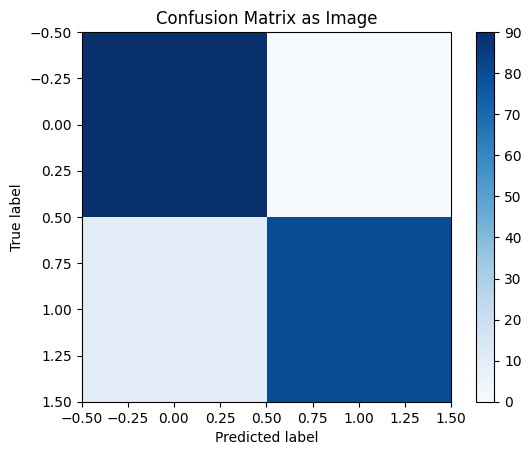

In [22]:
#Confusion Matrix generation (conf[0] is speech conf[1] is music)
conf_mat = np.zeros((2,2))
for i in range(speechTest.shape[1]//numTimeBins):
    speechSample = speechTest[:,i*numTimeBins: (i+1)*numTimeBins]
    musicSample = musicTest[:,i*numTimeBins: (i+1)* numTimeBins]

    if np.mean(LDAvector @ (speechSample - totalMean)) > 0 :
        conf_mat[0][0] += 1
    else:
        conf_mat[0][1] +=1
    
    if np.mean(LDAvector @ (musicSample - totalMean)) < 0 :
        conf_mat[1][1] += 1
    else:
        conf_mat[1][0] +=1


print(f"Total Test Accuracy: {np.sum(np.diag(conf_mat))/(speechTest.shape[1]//numTimeBins*2)}")
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix as Image')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [23]:
from scipy.io import wavfile

file_path_1 = 'recorded_speech.wav'

file_path_2 = 'downloaded_music10.wav'

sample_rate1, data1 = wavfile.read(file_path_1)

sample_rate2, data2 = wavfile.read(file_path_2)

__,__, dataSpeech = signal.stft(data1, window='hamming', nperseg=nperseg, noverlap=noverlap)
__,__, dataMusic = signal.stft(data2, window='hamming', nperseg=nperseg, noverlap=noverlap)
dataSpeech = np.log10(np.abs(dataSpeech) + 1e-7)
dataMusic = np.log10(np.abs(dataMusic) + 1e-7)



Recording of my Voice and My selected music Accuracy: 0.95
[[10.  0.]
 [ 1.  9.]]


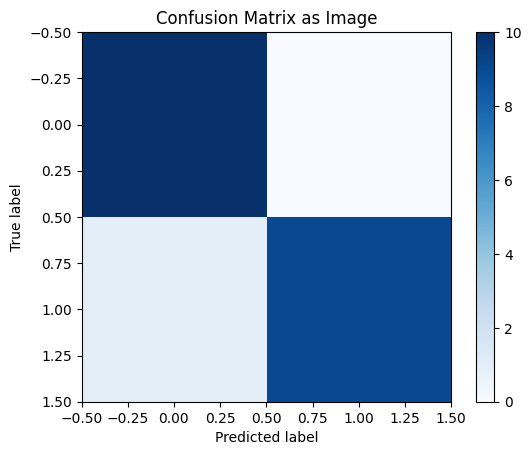

In [24]:
#Confusion Matrix generation (conf[0] is speech conf[1] is music)
conf_mat = np.zeros((2,2))
for i in range(dataMusic.shape[1]//numTimeBins):
    speechSample = dataSpeech[:,i*numTimeBins: (i+1)*numTimeBins]
    musicSample = dataMusic[:,i*numTimeBins: (i+1)* numTimeBins]

    if np.mean(LDAvector @ (speechSample - totalMean)) > 0 :
        conf_mat[0][0] += 1
    else:
        conf_mat[0][1] +=1
    
    if np.mean(LDAvector @ (musicSample - totalMean)) < 0 :
        conf_mat[1][1] += 1
    else:
        conf_mat[1][0] +=1


print(f"Recording of my Voice and My selected music Accuracy: {np.sum(np.diag(conf_mat))/(dataSpeech.shape[1]//numTimeBins*2)}")
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix as Image')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### We get great accuracy with 1 discriminant vector!!!

##